Import Library & Konfigurasi Awal

In [1]:
# --- CELL 1: Import Library ---
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Agar hasil eksperimen kita bisa diulang (tidak berubah-ubah setiap run)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    import random
    random.seed(seed)

set_seed(42)
print("Library berhasil di-import & Seed di-set!")

Library berhasil di-import & Seed di-set!


Konfigurasi Lokasi File

In [2]:
# --- CELL 2: Konfigurasi Path (DIPERBAIKI) ---
import os
import json

# ---------------------------------------------------------
# [Wajib Diisi] Ganti ini dengan lokasi folder project-mu di Windows
# Contoh: r"D:\Kuliah\Skripsi\Project_Xray"
DRIVE_PROJECT_DIR = r"D:\ComVis" 

# [Wajib Diisi] Lokasi folder tempat SEMUA gambar berada (induk folder)
# Jika folder gambar ada di dalam project, bisa gunakan os.path.join juga.
IMAGE_ROOT_DIR = r"D:\ComVis"
# ---------------------------------------------------------

# --- Bagian Path yang Kamu Minta ---
PATH_MAP_JSON = os.path.join(IMAGE_ROOT_DIR, 'filtered_filename_to_path_map.json')
TRAIN_CSV = os.path.join(DRIVE_PROJECT_DIR, 'filtered_train_split.csv')
VAL_CSV = os.path.join(DRIVE_PROJECT_DIR, 'filtered_val_split.csv')
TEST_CSV = os.path.join(DRIVE_PROJECT_DIR, 'filtered_test_split.csv')
# -----------------------------------

# Load Path Map (Peta Lokasi Gambar)
# Ini berguna agar komputer tahu persis ada di sub-folder mana setiap gambar
try:
    with open(PATH_MAP_JSON, 'r') as f:
        full_path_map = json.load(f)
    print("✅ File JSON Map berhasil dimuat!")
except FileNotFoundError:
    print(f"⚠️ Warning: File {PATH_MAP_JSON} tidak ditemukan.")
    print("Pastikan nama file benar. Kita akan mencoba mencari gambar langsung di IMAGE_ROOT_DIR.")
    full_path_map = {}

CONFIG = {
    'IMAGE_ROOT_DIR': IMAGE_ROOT_DIR,
    'TRAIN_CSV': TRAIN_CSV,
    'VAL_CSV': VAL_CSV,
    'TEST_CSV': TEST_CSV,
    'BATCH_SIZE': 16, 
    'IMAGE_SIZE': 224,
    'NUM_WORKERS': 0
}

LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
    'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

print(f"Konfigurasi selesai. Path Train CSV: {CONFIG['TRAIN_CSV']}")

✅ File JSON Map berhasil dimuat!
Konfigurasi selesai. Path Train CSV: D:\ComVis\filtered_train_split.csv


Membuat Class Dataset

In [3]:
# --- CELL 3: Custom Dataset Class (FIXED: Direct JSON Path) ---
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset

class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_cols=LABELS, path_map=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_cols = label_cols
        self.path_map = path_map
        
        self.file_names = self.df['Image Index'].values
        self.labels = self.df[self.label_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_path = None
        
        # --- LOGIKA BARU: Percaya pada JSON Map Dulu ---
        if self.path_map and img_name in self.path_map:
            # Ambil path mentah
            raw_path = self.path_map[img_name]
            
            # 1. Perbaiki Slash untuk Windows
            # Ubah semua '/' menjadi '\' agar Windows bisa baca
            norm_path = raw_path.replace('/', os.sep).replace('\\', os.sep)
            
            # Cek 1: Apakah path dari JSON ini valid dan file-nya ada?
            if os.path.exists(norm_path):
                img_path = norm_path
            else:
                # Cek 2: Jika path di JSON tidak ketemu (mungkin folder dipindah),
                # coba cari manual di root_dir pengguna.
                # Kita coba cari pola "images_XXX"
                parts = raw_path.replace('\\', '/').split('/')
                sub_folder = None
                for part in parts:
                    if part.startswith("images_") and part[7:].isdigit():
                        sub_folder = part
                        break
                
                if sub_folder:
                    # Coba struktur: Root/archive/images_XXX/images/file (Sesuai error log kamu)
                    try_path_1 = os.path.join(self.root_dir, 'archive', sub_folder, 'images', img_name)
                    # Coba struktur: Root/images_XXX/images/file
                    try_path_2 = os.path.join(self.root_dir, sub_folder, 'images', img_name)
                    
                    if os.path.exists(try_path_1):
                        img_path = try_path_1
                    elif os.path.exists(try_path_2):
                        img_path = try_path_2

        # Jika masih belum ketemu (atau tidak ada di map), fallback ke root
        if img_path is None:
            img_path = os.path.join(self.root_dir, img_name)
        
        # --- Debugging Akhir ---
        if not os.path.exists(img_path):
            # Tampilkan pesan error yang sangat detail
            raise FileNotFoundError(f"GAMBAR HILANG FINAL: {img_name}\n"
                                    f"Dicoba path 1 (JSON Direct): {norm_path if 'norm_path' in locals() else '-'}\n"
                                    f"Dicoba path 2 (Archive logic): {try_path_1 if 'try_path_1' in locals() else '-'}\n"
                                    f"Lokasi Root Dir: {self.root_dir}")

        # Baca Gambar
        image = cv2.imread(img_path)
        if image is None:
             raise FileNotFoundError(f"File ditemukan tapi corrupt/kosong: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, label

Membuat Transformasi & DataLoader

In [4]:
# --- CELL 4: Transforms & DataLoaders ---
# Load JSON Map-nya dulu (pastikan kode ini dijalankan sebelum membuat dataset)
import json
with open(PATH_MAP_JSON, 'r') as f:
    full_path_map = json.load(f)

# 1. Definisikan Augmentasi
def get_transforms(data_type):
    if data_type == 'train':
        return A.Compose([
            A.Resize(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']),
            A.HorizontalFlip(p=0.5),            # Kadang dibalik horizontal
            A.Rotate(limit=15, p=0.5),          # Kadang diputar sedikit
            A.RandomBrightnessContrast(p=0.2),  # Ubah kecerahan
            A.Normalize(
                mean=[0.485, 0.456, 0.406],     # Standar ImageNet
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        # Untuk Validasi/Test, kita HANYA resize dan normalize (jangan diacak-acak)
        return A.Compose([
            A.Resize(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])

# 2. Inisialisasi Dataset
# Masukkan map tersebut ke dataset
train_dataset = ChestXrayDataset(
    csv_file=CONFIG['TRAIN_CSV'], 
    root_dir=CONFIG['IMAGE_ROOT_DIR'], 
    transform=get_transforms('train'),
    path_map=full_path_map  # <--- PENTING: Masukkan ini!
)

val_dataset = ChestXrayDataset(
    csv_file=CONFIG['VAL_CSV'], 
    root_dir=CONFIG['IMAGE_ROOT_DIR'], 
    transform=get_transforms('val'),
    path_map=full_path_map  # <--- PENTING: Masukkan ini!
)

# 3. Buat DataLoader
# PERHATIAN: Di project serius, kita sering pakai WeightedRandomSampler untuk imbalance data.
# Untuk tahap awal ini, kita pakai shuffle=True dulu agar sederhana. 
# Nanti kita upgrade ke Sampler jika kode ini sudah jalan lancar.

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=True,  # <--- Balik ke Shuffle biasa
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=False, 
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

print("⚠️ Weighted Sampler dinonaktifkan. Menggunakan Shuffle biasa.")
print(f"Data Loaded!")
print(f"Jumlah Data Train: {len(train_dataset)} gambar")
print(f"Jumlah Data Val  : {len(val_dataset)} gambar")

⚠️ Weighted Sampler dinonaktifkan. Menggunakan Shuffle biasa.
Data Loaded!
Jumlah Data Train: 28892 gambar
Jumlah Data Val  : 7128 gambar


Cek Apakah Data Berhasil Dibaca?

Shape Gambar Batch: torch.Size([16, 3, 224, 224])
Shape Label Batch : torch.Size([16, 13])


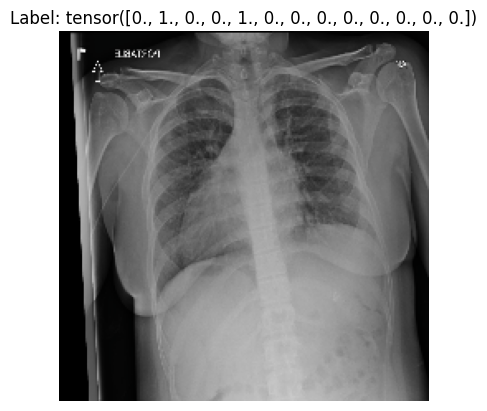

In [5]:
# --- CELL 5: Sanity Check ---
# Ambil 1 batch data
images, labels = next(iter(train_loader))

print(f"Shape Gambar Batch: {images.shape}") # Harus [Batch_Size, 3, 224, 224]
print(f"Shape Label Batch : {labels.shape}") # Harus [Batch_Size, 14]

# Tampilkan gambar pertama
img_show = images[0].permute(1, 2, 0).numpy()
# Denormalisasi agar warnanya kembali normal saat ditampilkan
img_show = img_show * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_show = np.clip(img_show, 0, 1)

plt.imshow(img_show)
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

Validasi Preprocessing & Augmentasi

Menampilkan contoh hasil Augmentasi pada Data Train...


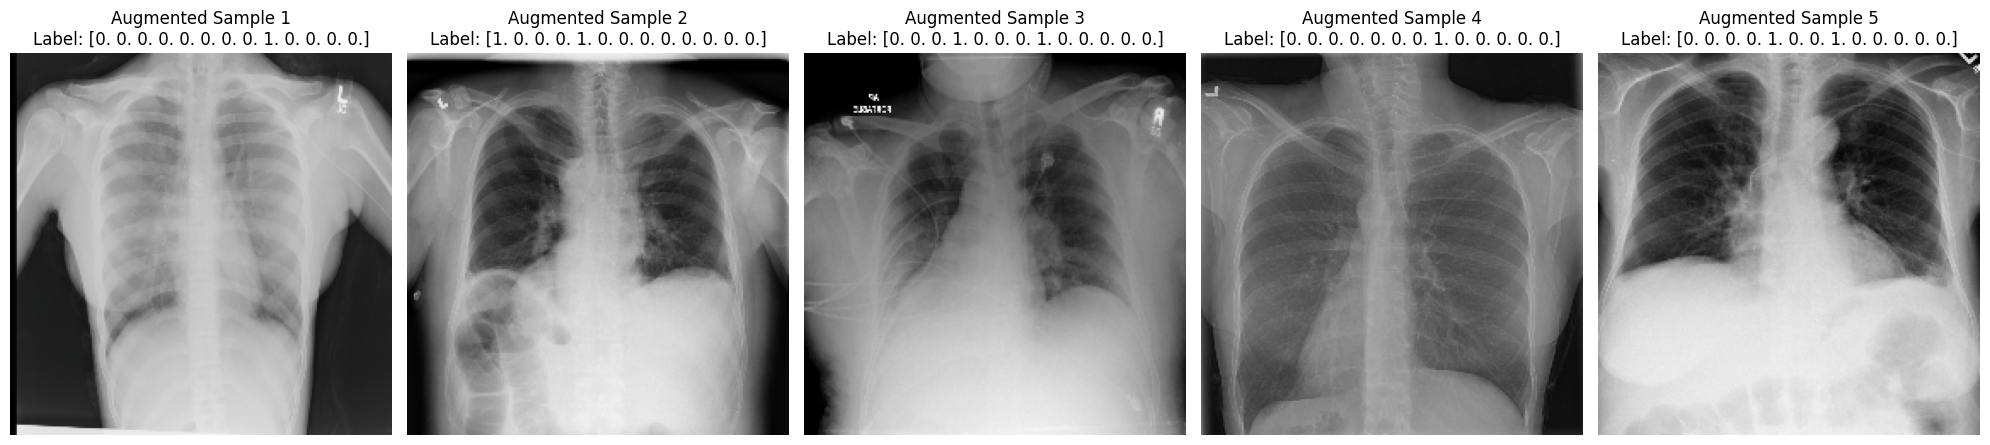

In [6]:
# --- CELL KHUSUS: Visualisasi Augmentasi ---
import matplotlib.pyplot as plt
import numpy as np

def visualize_augmentations(dataset, num_images=5):
    """
    Fungsi untuk mengintip hasil kerja Augmentasi & Preprocessing
    """
    # Kita ambil beberapa sampel secara acak
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    
    # Mean dan Std dari ImageNet (dipakai di preprocessing sebelumnya)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Karena gambar sudah jadi Tensor (C, H, W), kita ubah balik ke numpy (H, W, C)
        img_show = image.permute(1, 2, 0).numpy()
        
        # DENORMALISASI: Kembalikan warna asli agar bisa dilihat mata manusia
        # Rumus: (Gambar * std) + mean
        img_show = (img_show * std) + mean
        img_show = np.clip(img_show, 0, 1) # Pastikan nilai pixel antara 0-1
        
        # Tampilkan
        axes[i].imshow(img_show)
        axes[i].set_title(f"Augmented Sample {i+1}\nLabel: {label.numpy()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Menampilkan contoh hasil Augmentasi pada Data Train...")
visualize_augmentations(train_dataset)

Penanganan Imbalance (Poin 3)

In [7]:
# --- CELL: Imbalance Handling (Weighted Sampler) ---
from torch.utils.data import WeightedRandomSampler

def get_weighted_sampler(df, label_cols):
    # 1. Hitung jumlah kasus positif untuk setiap penyakit
    # (Semakin sedikit kasusnya, semakin besar bobot/prioritasnya)
    class_counts = df[label_cols].sum().values
    num_samples = len(df)
    
    # Hitung bobot per kelas (Penyakit langka dapat bobot besar)
    class_weights = num_samples / (class_counts + 1e-5) # +1e-5 biar tidak bagi nol
    
    # 2. Berikan bobot ke SETIAP GAMBAR di dataset
    sample_weights = []
    
    # Ambil label dalam bentuk array numpy biar cepat
    labels = df[label_cols].values
    
    print("Menghitung bobot sampling... (Mungkin butuh waktu sedikit)")
    
    # Strategi: Jika gambar punya penyakit 'langka', dia dapat bobot max dari penyakit tersebut
    for label in labels:
        # Cari indeks penyakit yang ada (bernilai 1)
        indices = np.where(label == 1)[0]
        
        if len(indices) > 0:
            # Jika sakit, ambil bobot terbesar dari penyakit yang diderita
            weight = np.max(class_weights[indices])
        else:
            # Jika sehat (No Finding), beri bobot kecil (rata-rata bobot penyakit / 10 misalnya)
            # Atau biarkan 0.1 agar model lebih fokus ke yang sakit
            weight = np.mean(class_weights) * 0.1 
            
        sample_weights.append(weight)
        
    sample_weights = torch.DoubleTensor(sample_weights)
    
    # 3. Buat Sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

# --- UPDATE DATALOADER ---
# Kita buat ulang train_loader dengan sampler baru
train_sampler = get_weighted_sampler(train_dataset.df, LABELS)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    sampler=train_sampler, # <--- KITA PASANG SAMPLER DISINI
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

print("✅ Train Loader berhasil di-update dengan Weighted Sampler!")

Menghitung bobot sampling... (Mungkin butuh waktu sedikit)
✅ Train Loader berhasil di-update dengan Weighted Sampler!


Membangun Arsitektur Model (DenseNet121)

In [8]:
# --- REVISI CELL 6: Model dengan Freezing Backbone ---
import timm
import torch.nn as nn

def create_frozen_model(num_classes):
    print("Menyiapkan model DenseNet121 (FROZEN BACKBONE)...")
    
    # 1. Load Model
    model = timm.create_model(
        'densenet121', 
        pretrained=True, 
        num_classes=num_classes,
        drop_rate=0.5  # <--- DROPOUT DIPERBESAR (0.5) BIAR LEBIH SUSAH NGHAFAL
    )
    
    # 2. FREEZE (BEKUKAN) SEMUA LAYER
    for param in model.parameters():
        param.requires_grad = False
    
    # 3. UNFREEZE (CAIRKAN) HANYA BAGIAN KEPALA (CLASSIFIER)
    # Di DenseNet timm, layer terakhir bernama 'classifier'
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    print("🔒 Backbone model dibekukan. Hanya classifier yang akan belajar.")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, device

# Buat model baru
model, device = create_frozen_model(num_classes=len(LABELS))

Menyiapkan model DenseNet121 (FROZEN BACKBONE)...
🔒 Backbone model dibekukan. Hanya classifier yang akan belajar.


Membuat Fungsi Training (Mesin Pelatih)

In [9]:
# --- CELL 7: Training Engine ---
from tqdm.notebook import tqdm # Loading bar yang cantik
from torchmetrics.classification import MultilabelAUROC

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train() # Mode Belajar ON
    running_loss = 0.0
    
    # Progress Bar
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # 1. Reset Gradient (Hapus memori sisa sebelumnya)
        optimizer.zero_grad()
        
        # 2. Model Menebak (Forward Pass)
        outputs = model(images)
        
        # 3. Hitung Kesalahan (Loss)
        loss = criterion(outputs, labels)
        
        # 4. Koreksi Model (Backward Pass)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    return running_loss / len(loader)

def validate_epoch(model, loader, criterion, device, num_classes):
    model.eval() # Mode Ujian ON (Matikan dropout, dll)
    running_loss = 0.0
    
    # Siapkan penilai AUC (Standar Medis)
    metric_auc = MultilabelAUROC(num_labels=num_classes, average="macro", thresholds=None)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Jangan hitung gradient pas ujian (hemat memori)
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Simpan prediksi untuk hitung skor akhir
            # Kita butuh probabilitas (0-1), jadi pakai Sigmoid
            preds = torch.sigmoid(outputs)
            metric_auc.update(preds, labels.long())
            
    # Hitung skor rata-rata
    epoch_auc = metric_auc.compute().item()
    metric_auc.reset()
    
    return running_loss / len(loader), epoch_auc

print("✅ Fungsi Training & Validasi siap!")

✅ Fungsi Training & Validasi siap!


Eksekusi Training (Mulai Belajar!)

In [10]:
# --- CELL 8: Training dengan Early Stopping & Regularization ---
import torch.optim as optim

# 1. Konfigurasi Hyperparameter
EPOCHS = 20              # Kita bisa set angka besar, nanti Early Stopping yang akan menghentikan
LEARNING_RATE = 1e-4     
CHECKPOINT_PATH = "best_model.pth"

# SETUP EARLY STOPPING
PATIENCE = 3            # Batas kesabaran: Jika 3x epoch tidak membaik, STOP.
early_stop_counter = 0  # Penghitung kegagalan

# 2. Setup Komponen Training
# Regularization 1: Weight Decay (Mencegah bobot model terlalu besar/menghafal)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)

# 3. Loop Training
best_auc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

print(f"🚀 Memulai Training (Maks {EPOCHS} Epoch) dengan Early Stopping...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # --- PHASE TRAIN ---
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # --- PHASE VALIDATION ---
    val_loss, val_auc = validate_epoch(model, val_loader, criterion, device, len(LABELS))
    
    # Update Scheduler
    scheduler.step(val_auc)
    
    # Simpan History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | LR: {current_lr:.6f}")
    
    # --- LOGIKA EARLY STOPPING ---
    if val_auc > best_auc:
        print(f"🌟 Skor Meningkat ({best_auc:.4f} -> {val_auc:.4f}). Menyimpan model & Reset Counter.")
        best_auc = val_auc
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        early_stop_counter = 0 # Reset kesabaran karena performa membaik
    else:
        early_stop_counter += 1
        print(f"⚠️ Skor tidak meningkat. Kesabaran: {early_stop_counter}/{PATIENCE}")
        
        if early_stop_counter >= PATIENCE:
            print("\n🛑 EARLY STOPPING TRIGGERED!")
            print("Model berhenti belajar karena tidak ada peningkatan performa (mencegah Overfitting).")
            break

print("\n🏁 Training Selesai!")
print(f"Model terbaik tersimpan dengan AUC: {best_auc:.4f}")

🚀 Memulai Training (Maks 20 Epoch) dengan Early Stopping...

Epoch 1/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3891 | Val Loss: 0.3212 | Val AUC: 0.6171 | LR: 0.000100
🌟 Skor Meningkat (0.0000 -> 0.6171). Menyimpan model & Reset Counter.

Epoch 2/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3740 | Val Loss: 0.3174 | Val AUC: 0.6453 | LR: 0.000100
🌟 Skor Meningkat (0.6171 -> 0.6453). Menyimpan model & Reset Counter.

Epoch 3/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3710 | Val Loss: 0.3166 | Val AUC: 0.6561 | LR: 0.000100
🌟 Skor Meningkat (0.6453 -> 0.6561). Menyimpan model & Reset Counter.

Epoch 4/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3670 | Val Loss: 0.3109 | Val AUC: 0.6632 | LR: 0.000100
🌟 Skor Meningkat (0.6561 -> 0.6632). Menyimpan model & Reset Counter.

Epoch 5/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3640 | Val Loss: 0.3132 | Val AUC: 0.6657 | LR: 0.000100
🌟 Skor Meningkat (0.6632 -> 0.6657). Menyimpan model & Reset Counter.

Epoch 6/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3643 | Val Loss: 0.3115 | Val AUC: 0.6696 | LR: 0.000100
🌟 Skor Meningkat (0.6657 -> 0.6696). Menyimpan model & Reset Counter.

Epoch 7/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3644 | Val Loss: 0.3094 | Val AUC: 0.6714 | LR: 0.000100
🌟 Skor Meningkat (0.6696 -> 0.6714). Menyimpan model & Reset Counter.

Epoch 8/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3623 | Val Loss: 0.3088 | Val AUC: 0.6736 | LR: 0.000100
🌟 Skor Meningkat (0.6714 -> 0.6736). Menyimpan model & Reset Counter.

Epoch 9/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3620 | Val Loss: 0.3090 | Val AUC: 0.6755 | LR: 0.000100
🌟 Skor Meningkat (0.6736 -> 0.6755). Menyimpan model & Reset Counter.

Epoch 10/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3612 | Val Loss: 0.3093 | Val AUC: 0.6748 | LR: 0.000100
⚠️ Skor tidak meningkat. Kesabaran: 1/3

Epoch 11/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3613 | Val Loss: 0.3084 | Val AUC: 0.6768 | LR: 0.000100
🌟 Skor Meningkat (0.6755 -> 0.6768). Menyimpan model & Reset Counter.

Epoch 12/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3609 | Val Loss: 0.3085 | Val AUC: 0.6776 | LR: 0.000100
🌟 Skor Meningkat (0.6768 -> 0.6776). Menyimpan model & Reset Counter.

Epoch 13/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3629 | Val Loss: 0.3074 | Val AUC: 0.6794 | LR: 0.000100
🌟 Skor Meningkat (0.6776 -> 0.6794). Menyimpan model & Reset Counter.

Epoch 14/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3611 | Val Loss: 0.3087 | Val AUC: 0.6789 | LR: 0.000100
⚠️ Skor tidak meningkat. Kesabaran: 1/3

Epoch 15/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3612 | Val Loss: 0.3095 | Val AUC: 0.6786 | LR: 0.000010
⚠️ Skor tidak meningkat. Kesabaran: 2/3

Epoch 16/20


Training:   0%|          | 0/1806 [00:00<?, ?it/s]

Validating:   0%|          | 0/446 [00:00<?, ?it/s]

Train Loss: 0.3617 | Val Loss: 0.3086 | Val AUC: 0.6786 | LR: 0.000010
⚠️ Skor tidak meningkat. Kesabaran: 3/3

🛑 EARLY STOPPING TRIGGERED!
Model berhenti belajar karena tidak ada peningkatan performa (mencegah Overfitting).

🏁 Training Selesai!
Model terbaik tersimpan dengan AUC: 0.6794


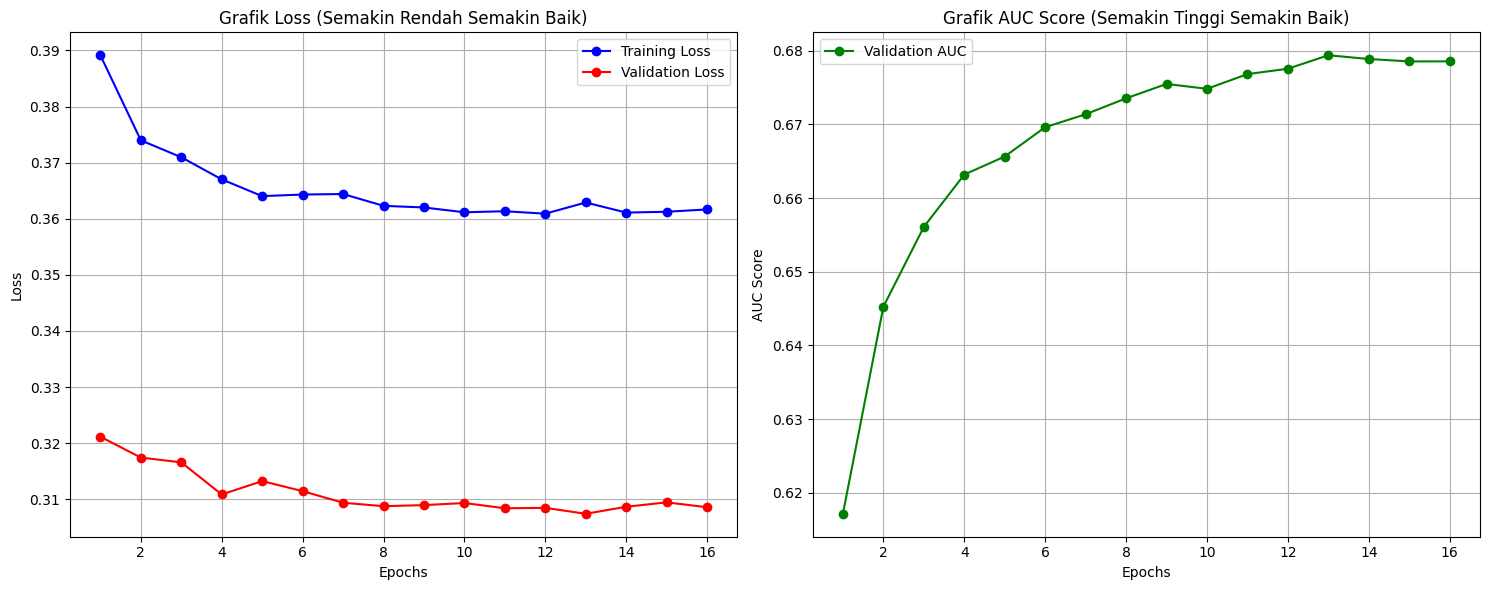

In [11]:
# --- CELL 9: Visualisasi Performa Model ---
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Ambil data dari dictionary history
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_auc = history['val_auc']
    
    epochs = range(1, len(train_loss) + 1)

    # Siapkan Canvas (Gambar) dengan ukuran lebar
    plt.figure(figsize=(15, 6))

    # --- GRAFIK 1: LOSS (Tingkat Kesalahan) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Grafik Loss (Semakin Rendah Semakin Baik)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- GRAFIK 2: AUC (Tingkat Akurasi Medis) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_auc, 'g-o', label='Validation AUC')
    plt.title('Grafik AUC Score (Semakin Tinggi Semakin Baik)')
    plt.xlabel('Epochs')
    plt.ylabel('AUC Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsinya
if 'history' in locals():
    plot_training_history(history)
else:
    print("Variabel 'history' tidak ditemukan. Pastikan proses training (Cell 8) sudah selesai dijalankan.")

In [12]:
print(f"Jumlah Gambar Train Asli: {len(train_dataset)}")
print(f"Jumlah Batch per Epoch: {len(train_loader)}")

Jumlah Gambar Train Asli: 28892
Jumlah Batch per Epoch: 1806
